## Ch02. 자연어와 단어의 분산 표현

#### 2.3.1 파이썬으로 말뭉치 전처리하기(1)

In [3]:
text='You say goodbye and I say hello'
print(text)

You say goodbye and I say hello


In [4]:
text=text.lower()
print(text)

you say goodbye and i say hello


In [5]:
text=text.replace('.','.')
print(text)

you say goodbye and i say hello


In [6]:
words=text.split(' ')
print(words)

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello']


In [7]:
word_to_id={} #단어에서 ID로 변환하기 위한 딕셔너리
id_to_word={} #단어 ID에서 단어로 변환하기 위한 딕셔너리
for word in words:
    if word not in word_to_id: #word_to_id에 없는 단어는 새로 추가
        new_id=len(word_to_id) #새로 추가할 단어의 ID는 현재의 word_to_id의 길이
        word_to_id[word]=new_id #새로운 단어와 ID를 추가
        id_to_word[new_id]=word #새로운 ID와 단어를 추가

In [8]:
id_to_word  

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}

In [9]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5}

In [10]:
id_to_word[1] #1번 단어

'say'

In [11]:
word_to_id['hello'] #hello의 ID

5

#### 2.3.1 파이썬으로 말뭉치 전처리하기(2)

In [ ]:
text='You say goodbye and I say hello'
print(text)

In [12]:
import numpy as np
corpus=[word_to_id[w] for w in words]
corpus=np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5])

In [ ]:
def preprocess(text):
    text=text.lower()
    text=text.replace('.','.')
    words=text.split(' ')
    
    word_to_id={}
    id_to_word={}
    for word in words:
        if word not in word_to_id:
            new_id=len(word_to_id)
            word_to_id[word]=new_id
            id_to_word[new_id]=word
            
    corpus=np.array([word_to_id[w] for w in words])
    
    return corpus,word_to_id,id_to_word

#### 2.3.4 동시발생 행렬

In [6]:
import sys
sys.path.append('.')
import numpy as np
from common.util import preprocess

text='You say goodbye and I say hello'
corpus,word_to_id,id_to_word=preprocess(text)
print(corpus)
print(word_to_id)   

[0 1 2 3 4 1 5]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5}


In [7]:
C=np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0]
],dtype=np.int32)

In [8]:
print(C[0]) #ID가 0인 단어의 단어 벡터

[0 1 0 0 0 0 0]


In [9]:
print(C[word_to_id['goodbye']]) #goodbye의 단어 벡터

[0 1 0 1 0 0 0]


#### <3주차 과제>

##### 동시발생 행렬 함수 구현

In [10]:
def create_co_matrix(corpus,vocab_size,window_size=1):
    corpus_size=len(corpus)
    co_matrix=np.zeros((vocab_size,vocab_size),dtype=np.int32)
    
    for idx,word_id in enumerate(corpus):
        for i in range(1,window_size+1):
            left_idx=idx-i
            right_idx=idx+i
            
            if left_idx>=0:
                left_word_id=corpus[left_idx]
                co_matrix[word_id,left_word_id]+=1
                
            if right_idx<corpus_size:
                right_word_id=corpus[right_idx]
                co_matrix[word_id,right_word_id]+=1
                
    return co_matrix

In [ ]:
create_co_matrix(corpus,len(word_to_id))


#### 2.3.5 벡터 간 유사도(1)

##### 코사인 유사도를 파이썬 함수로 구현

In [13]:
def cos_similarity(x,y):
    nx=x/np.sqrt(np.sum(x**2))
    ny=y/np.sqrt(np.sum(y**2))
    return np.dot(nx,ny)

##### 이 문제를 해결하는 방법, 나눌 때 작은값(epsilon)을 더해줌

In [14]:
def cos_similarity(x,y,eps=1e-8):
    nx=x/np.sqrt(np.sum(x**2)+eps)
    ny=y/np.sqrt(np.sum(y**2)+eps)
    return np.dot(nx,ny)

In [15]:
import sys
sys.path.append('.')
from common.util import preprocess,create_co_matrix,cos_similarity

text='You say goodbye and I say hello'
corpus,word_to_id,id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus,vocab_size)

c0=C[word_to_id['you']]
c1=C[word_to_id['i']]
print(cos_similarity(c0,c1))


0.7071067691154799


#### 2.3.6 유사 단어의 랭킹 표시

In [16]:
def most_similar(query,word_to_id,id_to_word,word_matrix,top=5):
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    print('\n[query]'+query)
    query_id=word_to_id[query]
    query_vec=word_matrix[query_id]
    
    vocab_size=len(id_to_word)
    similarity=np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i]=cos_similarity(word_matrix[i],query_vec)
        
    count=0
    for i in (-1*similarity).argsort():
        if id_to_word[i]==query:
            continue
        print(' %s: %s' % (id_to_word[i],similarity[i]))
        
        count+=1
        if count>=top:
            return

In [17]:
import sys
sys.path.append('.')
from common.util import preprocess,create_co_matrix,cos_similarity,most_similar

text='You say goodbye and I say hello'
corpus,word_to_id,id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus,vocab_size)

most_similar('you',word_to_id,id_to_word,C,top=5)


[query] you
 hello: 0.9999999800000005
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 say: 0.0
 and: 0.0


### 2.4 통계 기반 기법 개선하기

#### 2.4.1 상호정보량

#### 2.4.1 상호정보량(2)

In [18]:
def ppmi(C,verbose=False,eps=1e-8):
    M=np.zeros_like(C,dtype=np.float32)
    N=np.sum(C)
    S=np.sum(C,axis=0)
    total=C.shape[0]*C.shape[1]
    cnt=0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi=np.log2(C[i,j]*N/(S[j]*S[i])+eps)
            M[i,j]=max(0,pmi)
            
            if verbose:
                cnt+=1
                if cnt%(total//100)==0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [19]:
#coding: utf-8
import sys
sys.path.append('.')
import numpy as np
from common.util import preprocess,create_co_matrix,cos_similarity,most_similar,ppmi

text='You say goodbye and I say hello'
corpus,word_to_id,id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus,vocab_size)
W=ppmi(C)

np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0]
 [1 0 1 0 1 1]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 1 0 0 0 0]]
--------------------------------------------------
PPMI
[[0.    1.585 0.    0.    0.    0.   ]
 [1.585 0.    0.585 0.    0.585 1.585]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    0.    1.585 0.    1.585 0.   ]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    1.585 0.    0.    0.    0.   ]]


#### 2.4.2 차원감소

#### 2.4.3 SVD에 의한 차원 감소

##### SVD 구현

In [20]:
import sys
sys.path.append('.')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess,create_co_matrix,ppmi

text='You say goodbye and I say hello' 
corpus,word_to_id,id_to_word=preprocess(text)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus,vocab_size)
W=ppmi(C)

#SVD
U,S,V=np.linalg.svd(W)

In [21]:
print(C[0])

[0 1 0 0 0 0]


In [22]:
print(W[0])

[0.    1.585 0.    0.    0.    0.   ]


In [23]:
print(U[0])

[-0.452  0.     0.    -0.543  0.183 -0.683]


#### 2.4.3 SVD에 의한 차원 감소(1)

In [24]:
print(U[0,:2])

[-0.452  0.   ]


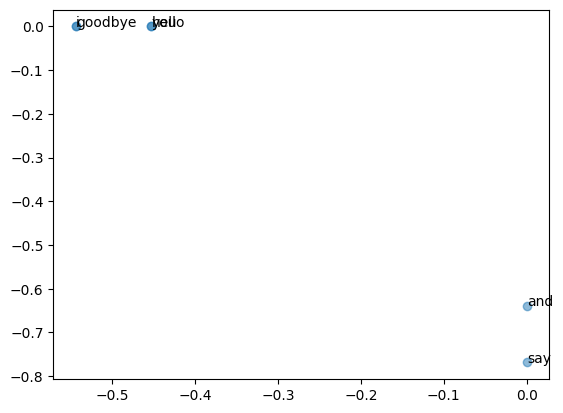

In [25]:
for word, word_id in word_to_id.items():
    plt.annotate(word,(U[word_id,0],U[word_id,1]))
plt.scatter(U[:,0],U[:,1],alpha=0.5)
plt.show()